INTRODUZIONE
...

INIZIO

Avendo svolto questo progetto tramite Google Colab, é stato necessario fare il mounting di un drive e la relativa prepazione delle cartelle e file necessari

In [ ]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

Fri Jul  4 09:51:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Montare Drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.makedirs('/content/drive/MyDrive/modelli_garbage', exist_ok=True)


Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/modelli_garbage/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!mkdir -p /content/CSV

In [ ]:
import os
data_dir = "/content/drive/MyDrive"

if not os.path.exists(f"{data_dir}/garbage_dataset"):
    !mkdir -p "{data_dir}"
    %cd "{data_dir}"
    !kaggle datasets download -d asdasdasasdas/garbage-classification -q
    !unzip -q garbage-classification.zip -d garbage_dataset
    print("Dataset scaricato e salvato su Drive.")
else:
    print("Dataset già presente su Drive.")


Dataset già presente su Drive.


Per prima cosa, avendo a disposizione un dataset i cui dati, nel nostro caso delle immagini, sono divisi per cartelle in base alla classe di appartenenza, assegneremo un label alle immagini in base alla cartella nella quale sono contenuti, secondo un dizionario in linea con il dataset.

In [ ]:
def class_from_paths(path):
  _, _, _, cl, _ = path.split('/')
  return class_dict[cl]

In [ ]:
from glob import glob

paths = glob(f'{data_dir}/garbage_dataset/Garbage classification/Garbage classification/*/*')
images_paths = ["/".join(p.split('/')[4:]) for p in paths]

In [ ]:
class_dict = {
    'glass': 1,
    'paper': 2,
    'cardboard': 3,
    'plastic': 4,
    'metal': 5,
    'trash': 6
}

In [ ]:
labels = [class_from_paths(im) for im in images_paths]
print(labels[:10])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


Fatto ciò, è stato creato una struttura tabellare che associa il path del dato alla corrispondente etichetta.

In [ ]:
import pandas as pd

dataset = pd.DataFrame({'path':images_paths, 'label':labels})
dataset[:10]

,path,label
0,garbage_dataset/Garbage classification/Garbage...,3
1,garbage_dataset/Garbage classification/Garbage...,3
2,garbage_dataset/Garbage classification/Garbage...,3
3,garbage_dataset/Garbage classification/Garbage...,3
4,garbage_dataset/Garbage classification/Garbage...,3
5,garbage_dataset/Garbage classification/Garbage...,3
6,garbage_dataset/Garbage classification/Garbage...,3
7,garbage_dataset/Garbage classification/Garbage...,3
8,garbage_dataset/Garbage classification/Garbage...,3
9,garbage_dataset/Garbage classification/Garbage...,3


Successivamente, sono stati divisi i dati in:
<ul>
<li> training set: 65% dei dati.
<li> validation set: 15% dei dati.
<li> test set: 20% dei dati.
</ul>

I dati verranno randomicamente divisi in questi tre set.

In [ ]:
from sklearn.model_selection import train_test_split

def split_train_val_test(dataset, perc=[0.65, 0.15, 0.2]):
    train, testval = train_test_split(dataset, test_size = perc[1]+perc[2])
    val, test = train_test_split(testval, test_size = perc[2]/(perc[1]+perc[2]))
    return train, val, test

In [ ]:
import numpy as np
import random

random.seed(123456789)
np.random.seed(987654321)
train, val, test = split_train_val_test(dataset)

print("Numero dati di training:", len(train))
print("Numero dati di validation:", len(val))
print("Numero dati di test:", len(test))

Numero dati di training: 1642
Numero dati di validation: 379
Numero dati di test: 506


Il risultato di questa separazione è stato poi salvato tre file '*.csv*', per un eventuale riutilizzo futuro.

In [ ]:
train.to_csv('/content/CSV/train.csv', index=None)
val.to_csv('/content/CSV/valid.csv', index=None)
test.to_csv('/content/CSV/test.csv', index=None)

In [ ]:
# classes, ids = zip(*class_dict.items())
# classes = pd.DataFrame({
#     'id': [i for i in ids],
#     'class': classes
# }).set_index('id')
# classes.to_csv('/content/CSV/classes.csv')

Creiamo ora la funzione *CSVImageDataset*, che verrà in seguito utilizzata

In [ ]:
from torch.utils import data
from os.path import join
from PIL import Image

class CSVImageDataset(data.Dataset):
    def __init__ (self, data_root, csv, transform = None):
        self.data_root = data_root
        self.data = pd.read_csv(csv)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        image_path, image_label = self.data.iloc[i]['path'], self.data.iloc[i].label
        image_label = image_label - 1

        images = Image.open(join(self.data_root,image_path)).convert('RGB')
        if self.transform is not None:
            images = self.transform(images)

        return images, image_label

In [ ]:
# # classes = pd.read_csv('/content/CSV/classes.csv').to_dict()['class']

# dataset_train = CSVImageDataset('','/content/CSV/train.csv')
# dataset_valid = CSVImageDataset('','/content/CSV/valid.csv')
# dataset_test = CSVImageDataset('','/content/CSV/test.csv')

# image, label = dataset_train[0]
# print('Class id:',label, 'Class name:',classes[label-1])
# image

In [ ]:
from torchvision import transforms
import torch, time

train_transform = transforms.Compose([
    transforms.Resize(400),
    transforms.RandomCrop(384),  #384 perché EfficientNetV2_s é stata allenata su immagini di questa dimensione
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

#tolto transforms.RandomHorizontalFlip()
test_transform = transforms.Compose([
    transforms.Resize(400),
    transforms.CenterCrop(384),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229,0.224,0.225])
])

In [ ]:
garbage_train = CSVImageDataset(f'{data_dir}', '/content/CSV/train.csv', transform = train_transform)
garbage_valid = CSVImageDataset(f'{data_dir}', '/content/CSV/valid.csv', transform = test_transform)
garbage_test = CSVImageDataset(f'{data_dir}','/content/CSV/test.csv', transform = test_transform)

In [ ]:
#rivedere size del batch

from torch.utils.data import DataLoader

garbage_train_loader = DataLoader(garbage_train,  batch_size=32, num_workers=2,  shuffle=True)
garbage_valid_loader = DataLoader(garbage_valid,  batch_size=32, num_workers=2)
garbage_test_loader = DataLoader(garbage_test, batch_size=32,  num_workers=2)

In [ ]:
#passa all'uso della GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo attivo:", device)

Dispositivo attivo: cuda


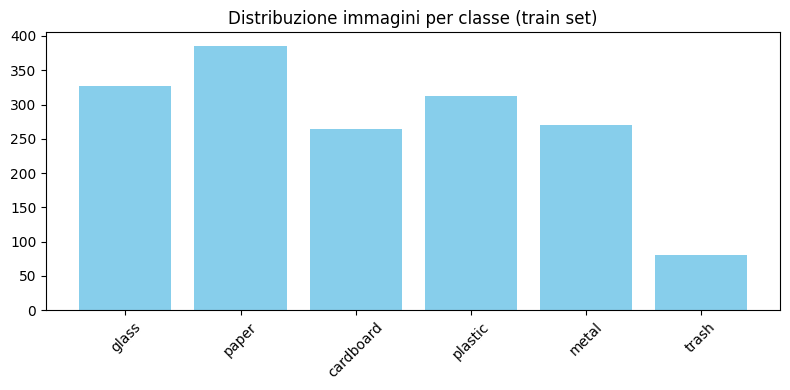

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

labels = [label for _, label in garbage_train]

# Conta le label
label_counts = Counter(labels)

inv_class_dict = {v-1: k for k, v in class_dict.items()}

# Grafico
plt.figure(figsize=(8, 4))
plt.bar([inv_class_dict[i] for i in sorted(label_counts.keys())],
        [label_counts[i] for i in sorted(label_counts.keys())],
        color='skyblue')
plt.xticks(rotation=45)
plt.title('Distribuzione immagini per classe (train set)')
plt.tight_layout()
plt.show()


In [ ]:
#DATA AUGUMENTATION DINAMICA PER CLASSE TRASH
from torch.utils.data import Dataset, ConcatDataset, Subset

class5_indices = [i for i, (_, label) in enumerate(garbage_train) if label == 5]

class5_augmented = Subset(garbage_train, class5_indices)

augmented_datasets = [class5_augmented for _ in range(2)]  #CAMBIARE PER AUMENTARE/DIMINUIRE DATI

balanced_dataset = ConcatDataset([garbage_train] + augmented_datasets)

garbage_train_loader = DataLoader(balanced_dataset, batch_size=32, num_workers=2, shuffle=True, pin_memory=True)


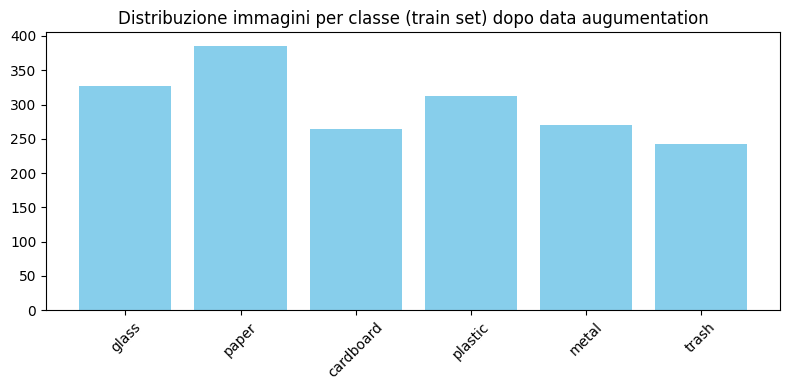

In [ ]:
labels = [label for _, label in garbage_train_loader.dataset]  # usa __getitem__

# Conta le label
label_counts = Counter(labels)

class_names = garbage_train_loader.dataset.classes if hasattr(garbage_train_loader.dataset, 'classes') else sorted(set(labels))

# Grafico
plt.figure(figsize=(8, 4))
plt.bar([inv_class_dict[i] for i in sorted(label_counts.keys())],
        [label_counts[i] for i in sorted(label_counts.keys())],
        color='skyblue')
plt.xticks(rotation=45)
plt.title('Distribuzione immagini per classe (train set) dopo data augumentation')
plt.tight_layout()
plt.show()


In [ ]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import timm, torch.nn as nn

weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights)
num_classes = len(class_dict)
print(num_classes)
model.classifier[1] = nn.Linear(
        in_features = model.classifier[1].in_features,
        out_features = num_classes)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 163MB/s]


6


In [ ]:
from torch.optim import SGD

def train_validate(model, garbage_train_loader, garbage_valid_loader,
                   epochs=5, lr=1e-3, momentum=0.9,
                   device=None, log_every=50,
                   resume_from=None):

    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)
    best_val_acc = 0
    best_val_loss = 1

    start_epoch = 1

    patience = 5
    patience_counter = 0

    # Riprendi da checkpoint se fornito
    if resume_from:
        checkpoint = torch.load(resume_from)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_acc = checkpoint.get('best_val_acc', 0)
        print(f"Ripreso da: {resume_from} | epoca {start_epoch} | best_acc: {best_val_acc:.3f}")

    num_model_classes = model.classifier[-1].out_features
    save_dir = '/content/drive/MyDrive/modelli_garbage'
    os.makedirs(save_dir, exist_ok=True)

    for ep in range(start_epoch, epochs + 1):
        model.train()
        running_loss, running_acc, seen = 0, 0, 0
        t0 = time.time()

        for step, (x, y) in enumerate(garbage_train_loader, 1):
            x = x.to(device)
            y = y.to(device)

            if step == 1 and ep == 1:
                print(f"Label originali: min={y.min()}, max={y.max()}, unique={torch.unique(y)}")
                print(f"Numero classi modello: {num_model_classes}")

            assert y.min() >= 0, f"Label negativa: {y.min()}"
            assert y.max() < num_model_classes, f"Label {y.max()} >= num_classes {num_model_classes}"

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            n = x.size(0)
            running_loss += loss.item() * n
            running_acc  += (out.argmax(1) == y).sum().item()
            seen += n

            if step % log_every == 0:
                print(f'Epoch {ep} | step {step}/{len(garbage_train_loader)} '
                      f'loss {running_loss/seen:.4f} acc {running_acc/seen:.3f}')

        # VALIDAZIONE
        model.eval()
        val_loss, val_acc, seen = 0, 0, 0
        with torch.no_grad():
            for x, y in garbage_valid_loader:
                x, y = x.to(device), y.to(device)
                if y.min() > 0:
                    y = y - 1

                out = model(x)
                val_loss += criterion(out, y).item() * x.size(0)
                val_acc  += (out.argmax(1) == y).sum().item()
                seen += x.size(0)

        val_loss /= seen
        val_acc  /= seen
        dt = time.time() - t0
        print(f'- Epoch {ep} done in {dt:.1f}s | val_loss {val_loss:.4f} val_acc {val_acc:.3f}')

        #SALVA MIGLIOR MODELLO
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save({
                'epoch': ep,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'loss': val_loss
            }, f'{save_dir}/best_model.pt')
            print('  ✓ checkpoint salvato (miglior modello)')
        else:
            patience_counter += 1
            print(f"- Early stopping counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping attivato.")
                break

        #SALVA OGNI 2 EPOCHE PERCHE VOLEVO PROVARE MA DA MODIFICARE
        if ep % 2 == 0:
            torch.save({
                'epoch': ep,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'loss': val_loss
            }, f'{save_dir}/checkpoint_epoch{ep}.pth')
            print(f' checkpoint completo salvato: checkpoint_epoch{ep}.pth')

    print('Miglior accuratezza validazione:', best_val_acc)
    return model


In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model = train_validate(
        model,
        garbage_train_loader = garbage_train_loader,
        garbage_valid_loader = garbage_valid_loader,
        epochs       = 20,
        lr           = 1e-3,
        momentum     = 0.9,
        device       = device,
        log_every    = 50,
        resume_from='/content/drive/MyDrive/modelli_garbage/checkpoint_epoch10.pth'
)

Ripreso da: /content/drive/MyDrive/modelli_garbage/checkpoint_epoch10.pth | epoca 11 | best_acc: 0.931
Epoch 11 | step 50/57 loss 0.0894 acc 0.980
- Epoch 11 done in 104.7s | val_loss 0.2520 val_acc 0.929
- Early stopping counter: 1/3
Epoch 12 | step 50/57 loss 0.0711 acc 0.982
- Epoch 12 done in 65.3s | val_loss 0.2661 val_acc 0.918
- Early stopping counter: 2/3
 checkpoint completo salvato: checkpoint_epoch12.pth
Epoch 13 | step 50/57 loss 0.0576 acc 0.986
- Epoch 13 done in 68.9s | val_loss 0.2662 val_acc 0.929
- Early stopping counter: 3/3
Early stopping attivato.
Miglior accuratezza validazione: 0.9313984168865436


In [ ]:
#  SALVA E SCARICA IL MODELLO DA COLAB

torch.save(model.state_dict(), '/content/efficientnet_garbage.pth')
print(" Modello salvato localmente in /content/efficientnet_garbage.pth")

from google.colab import files
files.download('/content/efficientnet_garbage.pth')


 Modello salvato localmente in /content/efficientnet_garbage.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import torch.optim as optim
# from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate(model, loader, device=None, target_names=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval().to(device)
    # correct = 0
    # total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).argmax(1)
            # _, preds = torch.max(outputs, 1)
            # correct += (outputs == labels).sum().item()
            # total += labels.size(0)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # Calcolo metriche
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print("\n Confusion Matrix:")
    print(cm)

    # Report dettagliato (opzionale)
    if target_names:
        print("\n Classification Report:")
        print(classification_report(all_labels, all_preds, target_names=target_names))

    return acc, prec, rec, f1, cm

# acc = evaluate(model, garbage_valid_loader)
# print(f'Validation Accuracy: {acc:.4f}')
# model.load_state_dict(torch.load('best_model.pt'))
# evaluate(model, garbage_test_loader)


In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/modelli_garbage/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
# ho cambiato perché non mi workava

# model.load_state_dict(torch.load('/content/drive/MyDrive/modelli_garbage/best_model.pt'))
acc, prec, rec, f1, cm = evaluate(model, garbage_test_loader, target_names=['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash'])


Accuracy     : 0.9249
Precision    : 0.9256
Recall       : 0.9249
F1 Score     : 0.9251

 Confusion Matrix:
[[ 82   0   0   5   2   0]
 [  0 118   1   0   0   3]
 [  0   3  84   1   0   0]
 [  8   1   0  84   3   1]
 [  1   0   0   5  75   1]
 [  0   0   0   1   2  25]]

 Classification Report:
              precision    recall  f1-score   support

       glass       0.90      0.92      0.91        89
       paper       0.97      0.97      0.97       122
   cardboard       0.99      0.95      0.97        88
     plastic       0.88      0.87      0.87        97
       metal       0.91      0.91      0.91        82
       trash       0.83      0.89      0.86        28

    accuracy                           0.92       506
   macro avg       0.91      0.92      0.92       506
weighted avg       0.93      0.92      0.93       506



In [ ]:
# Visualizziamo la Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, loader, class_names, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval().to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).argmax(1)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_metrics_bar(acc, prec, rec, f1):
    import matplotlib.pyplot as plt

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [acc, prec, rec, f1]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(metrics, values, color=['#4CAF50', '#2196F3', '#FFC107', '#F44336'])
    plt.ylim(0, 1)
    plt.title('Altre metriche di classificazione')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 0.02, f"{yval:.2f}", fontsize=10)
    plt.tight_layout()
    plt.show()


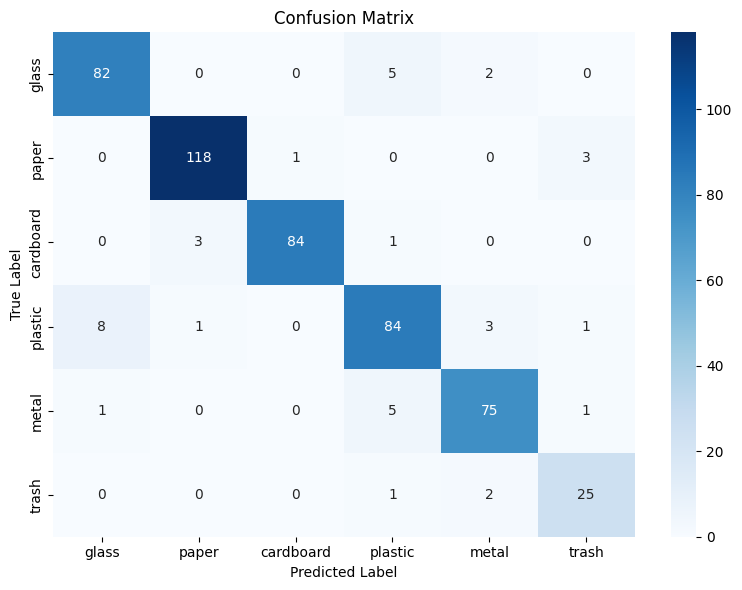

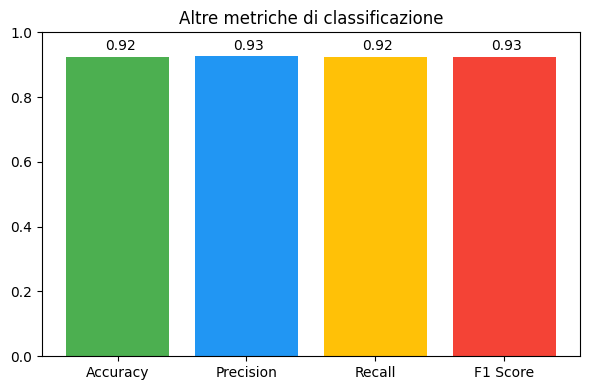

In [ ]:
plot_confusion_matrix(model, garbage_test_loader, class_names=['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash'])

plot_metrics_bar(acc, prec, rec, f1)

✓ Modello caricato da: /content/drive/MyDrive/modelli_garbage/best_model.pt

 Accuracy sul validation set: 0.9249

Classification Report:
              precision    recall  f1-score   support

       glass       0.90      0.92      0.91        89
       paper       0.97      0.97      0.97       122
   cardboard       0.99      0.95      0.97        88
     plastic       0.88      0.87      0.87        97
       metal       0.91      0.91      0.91        82
       trash       0.83      0.89      0.86        28

    accuracy                           0.92       506
   macro avg       0.91      0.92      0.92       506
weighted avg       0.93      0.92      0.93       506



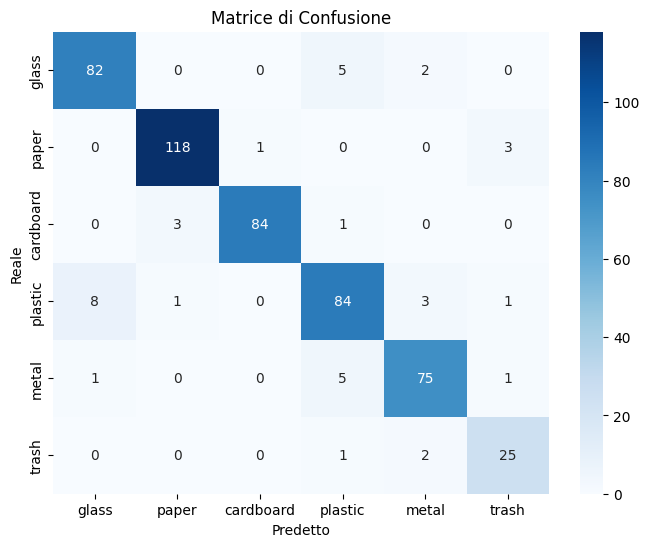

In [ ]:
# import torch
# import torch.nn as nn
# from sklearn.metrics import classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import os

def test_model(model, dataloader, checkpoint_path, device=None, class_names=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint non trovato: {checkpoint_path}")

    # Carica stato del modello
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Modello caricato da: {checkpoint_path}")

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = (all_preds == all_labels).mean()
    print(f"\n Accuracy sul validation set: {acc:.4f}\n")

    # Class names
    if class_names is None:
        class_names = [str(i) for i in sorted(set(all_labels))]

    # Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predetto')
    plt.ylabel('Reale')
    plt.title('Matrice di Confusione')
    plt.show()

# ESEMPIO DI USO (modifica se usi altro modello/checkpoint)
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

# Carica il modello con pesi base
model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
num_classes = 6
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)

# Path al checkpoint migliore
best_model_path = '/content/drive/MyDrive/modelli_garbage/best_model.pt'

# Nomi delle classi (ordinati secondo label numerici)
class_names = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']

# Avvia il test
test_model(model, garbage_test_loader, best_model_path, class_names=class_names)
